# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce
import datetime

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Get all the Data, Build all the Graphs

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
science_repo_sql = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                    --science 
                    SELECT
                    	repo_git, ntile(4) over ( order by commits_all_time) 
                    FROM
                    	repo A,
                    	(
                    	SELECT C.repo_id, d.commits_all_time
                    	FROM
                    		augur_operations.users A,
                    		augur_operations.user_groups b,
                    		augur_operations.user_repos C, 
                    		api_get_all_repos_commits d 
                    	WHERE
                    		A.user_id = b.user_id 
                    		AND b.group_id = C.group_id 
                    		AND d.repo_id= c.repo_id
                    		AND b.NAME = 'science' --AND lower(A.login_name)='numfocus'
                    		
                    	ORDER BY
                    		A.login_name,
                    		d.commits_all_time,
                    		b.group_id 
                    	) b 
                    WHERE
                    	A.repo_id = b.repo_id order by commits_all_time desc
                            """)

with engine.connect() as conn:
    #df = pd.read_sql(sql, cnxn)
    results = conn.execute(science_repo_sql)
    df_results = pd.DataFrame(results) 

print(df_results)

                                               repo_git  ntile
0           https://github.com/rstudio/gcc-darwin-arm64      4
1           https://github.com/rstudio/vscode-workbench      4
2                        https://github.com/rails/rails      4
3                         https://github.com/jabref/jdk      4
4               https://github.com/lockss/lockss-daemon      4
...                                                 ...    ...
1904                   https://github.com/ropensci/deck      1
1905  https://github.com/bioconductor/rgalaxy-rnaseq...      1
1906     https://github.com/jabref/translate.jabref.org      1
1907          https://github.com/iqss/dvn-icpsr-wrapper      1
1908               https://github.com/rails/hide_action      1

[1909 rows x 2 columns]


,repo_git,ntile
0,https://github.com/rstudio/gcc-darwin-arm64,4
1,https://github.com/rstudio/vscode-workbench,4
2,https://github.com/rails/rails,4
3,https://github.com/jabref/jdk,4
4,https://github.com/lockss/lockss-daemon,4
...,...,...
1904,https://github.com/ropensci/deck,1
1905,https://github.com/bioconductor/rgalaxy-rnaseq...,1
1906,https://github.com/jabref/translate.jabref.org,1
1907,https://github.com/iqss/dvn-icpsr-wrapper,1


array([1, 2, 3, 4])

Graphs for NTILE: 1
Starting Data Collection for NTILE: 1
current time:- 2023-07-06 19:13:13.763021
Graphs for NTILE: 1
Finished itertuples for NTILE: 1
current time:- 2023-07-06 19:15:43.870447
(25550,26717,27545,31442,27983,28225,29926,29006,29698,30401,32143,29161,26790,28538,26283,27472,30312,31376,25729,26347,25697,29482,25561,26308,29718,29377,30684,29642,32154,30223,29029,25711,25693,29394,26679,26600,31410,30060,29883,30338,26639,32158,29721,31520,26853,30598,27478,28212,25731,27424,27625,30403,27557,28264,26810,27637,27334,31470,28486,28042,25623,30983,29969,31865,31850,29401,26325,31761,32108,25641,32140,28668,28176,32313,29733,30901,28271,29015,25565,29612,30134,26713,26865,29913,29264,28708,28544,29900,27358,27879,25699,25716,27396,27693,26998,29920,25687,27032,25712,29141,29034,26612,27961,25694,25698,29559,29450,28048,29873,29971,29627,31458,31265,26987,31327,30296,29931,25597,26816,29975,26409,31224,30629,29471,32369,32287,32254,30001,30095,31888,30316,30049,29940,31369,

,repo_id,repo_git,cntrb_id,issue_id
0,25550,https://github.com/jupyterhub/jupyterhub-examp...,0100111f-cb00-0000-0000-000000000000,39564
1,28225,https://github.com/iqss/doi2pmh-server,0100bf6c-c500-0000-0000-000000000000,47169
2,32284,https://github.com/ropenscilabs/annual-report-...,010008d0-8400-0000-0000-000000000000,43676
3,29721,https://github.com/rstudio/issuetriager,01000003-d700-0000-0000-000000000000,43435
4,27824,https://github.com/iqss/plaid,01000052-0e00-0000-0000-000000000000,43124
...,...,...,...,...
813,29883,https://github.com/jupyter/newsletter,0100e5bc-3800-0000-0000-000000000000,51001
814,29883,https://github.com/jupyter/newsletter,010028e8-9400-0000-0000-000000000000,51002
815,29883,https://github.com/jupyter/newsletter,010028e8-9400-0000-0000-000000000000,51003
816,29883,https://github.com/jupyter/newsletter,010000e0-3200-0000-0000-000000000000,51004


Graphs for NTILE: 1
Ending Data Collection for ISSUES in NTILE: 1
current time:- 2023-07-06 19:15:44.214730


,repo_id,repo_git,cntrb_id,pull_request_id
0,30604,https://github.com/ropensci/software-review-meta,01007f92-9500-0000-0000-000000000000,59255
1,25711,https://github.com/lockss/plnmonitor-daemon,0100b1d6-8300-0000-0000-000000000000,48468
2,26281,https://github.com/artefactual/archivematica-f...,010011c1-1900-0000-0000-000000000000,49121
3,26281,https://github.com/artefactual/archivematica-f...,010011c1-1900-0000-0000-000000000000,49122
4,26281,https://github.com/artefactual/archivematica-f...,010011c1-1900-0000-0000-000000000000,49122
...,...,...,...,...
1066,30050,https://github.com/rails/verification,01000010-7f00-0000-0000-000000000000,48633
1067,29999,https://github.com/rails/auto_complete,01000631-3c00-0000-0000-000000000000,49287
1068,29999,https://github.com/rails/auto_complete,010002df-f700-0000-0000-000000000000,49288
1069,30020,https://github.com/rails/ssl_requirement,0100035c-fa00-0000-0000-000000000000,48985


Graphs for NTILE: 1
Ending Data Collection for PULL REQUESTS in NTILE: 1
current time:- 2023-07-06 19:15:45.032036


,repo_id,repo_git,cntrb_id,pull_request_id
0,25602,https://github.com/jupyterhub/jupyterhub.githu...,01000251-7900-0000-0000-000000000000,48170
1,25602,https://github.com/jupyterhub/jupyterhub.githu...,0102ab29-fd00-0000-0000-000000000000,48170
2,26283,https://github.com/artefactual/binder-docs,01006e54-a100-0000-0000-000000000000,48193
3,29718,https://github.com/rstudio/go-pep440-version,01010908-b700-0000-0000-000000000000,48583
4,28212,https://github.com/iqss/dataverse-tv,01000052-0e00-0000-0000-000000000000,28268536
...,...,...,...,...
120,27557,https://github.com/vufind-org/vufind-marc,01001442-2b00-0000-0000-000000000000,48419
121,27557,https://github.com/vufind-org/vufind-marc,010004b7-4d00-0000-0000-000000000000,48419
122,27557,https://github.com/vufind-org/vufind-marc,010004b7-4d00-0000-0000-000000000000,48419
123,27545,https://github.com/vufind-org/vufinddate,01001442-2b00-0000-0000-000000000000,48395


Graphs for NTILE: 1
Ending Data Collection for PR REVIEWERS in NTILE: 1
current time:- 2023-07-06 19:15:46.525269


,repo_id,repo_git,cntrb_id,cmt_id
0,29394,https://github.com/rstudio/rstudio-shields,0100016c-2f00-0000-0000-000000000000,1196964
1,29394,https://github.com/rstudio/rstudio-shields,0100016c-2f00-0000-0000-000000000000,1196947
2,27658,https://github.com/iqss/vagrant-at-iqss,01000052-0e00-0000-0000-000000000000,1181217
3,27658,https://github.com/iqss/vagrant-at-iqss,01000052-0e00-0000-0000-000000000000,1181223
4,27658,https://github.com/iqss/vagrant-at-iqss,01000052-0e00-0000-0000-000000000000,1181230
...,...,...,...,...
43067,25657,https://github.com/eka/superpowers-asset-packs,010006d2-0a00-0000-0000-000000000000,459705
43068,25657,https://github.com/eka/superpowers-asset-packs,010006d2-0a00-0000-0000-000000000000,459711
43069,25657,https://github.com/eka/superpowers-asset-packs,010006d2-0a00-0000-0000-000000000000,459717
43070,25657,https://github.com/eka/superpowers-asset-packs,010006d2-0a00-0000-0000-000000000000,459724


Completed ALL Data Collection for NTILE: 1
current time:- 2023-07-06 19:16:06.705772
commit contributor graph


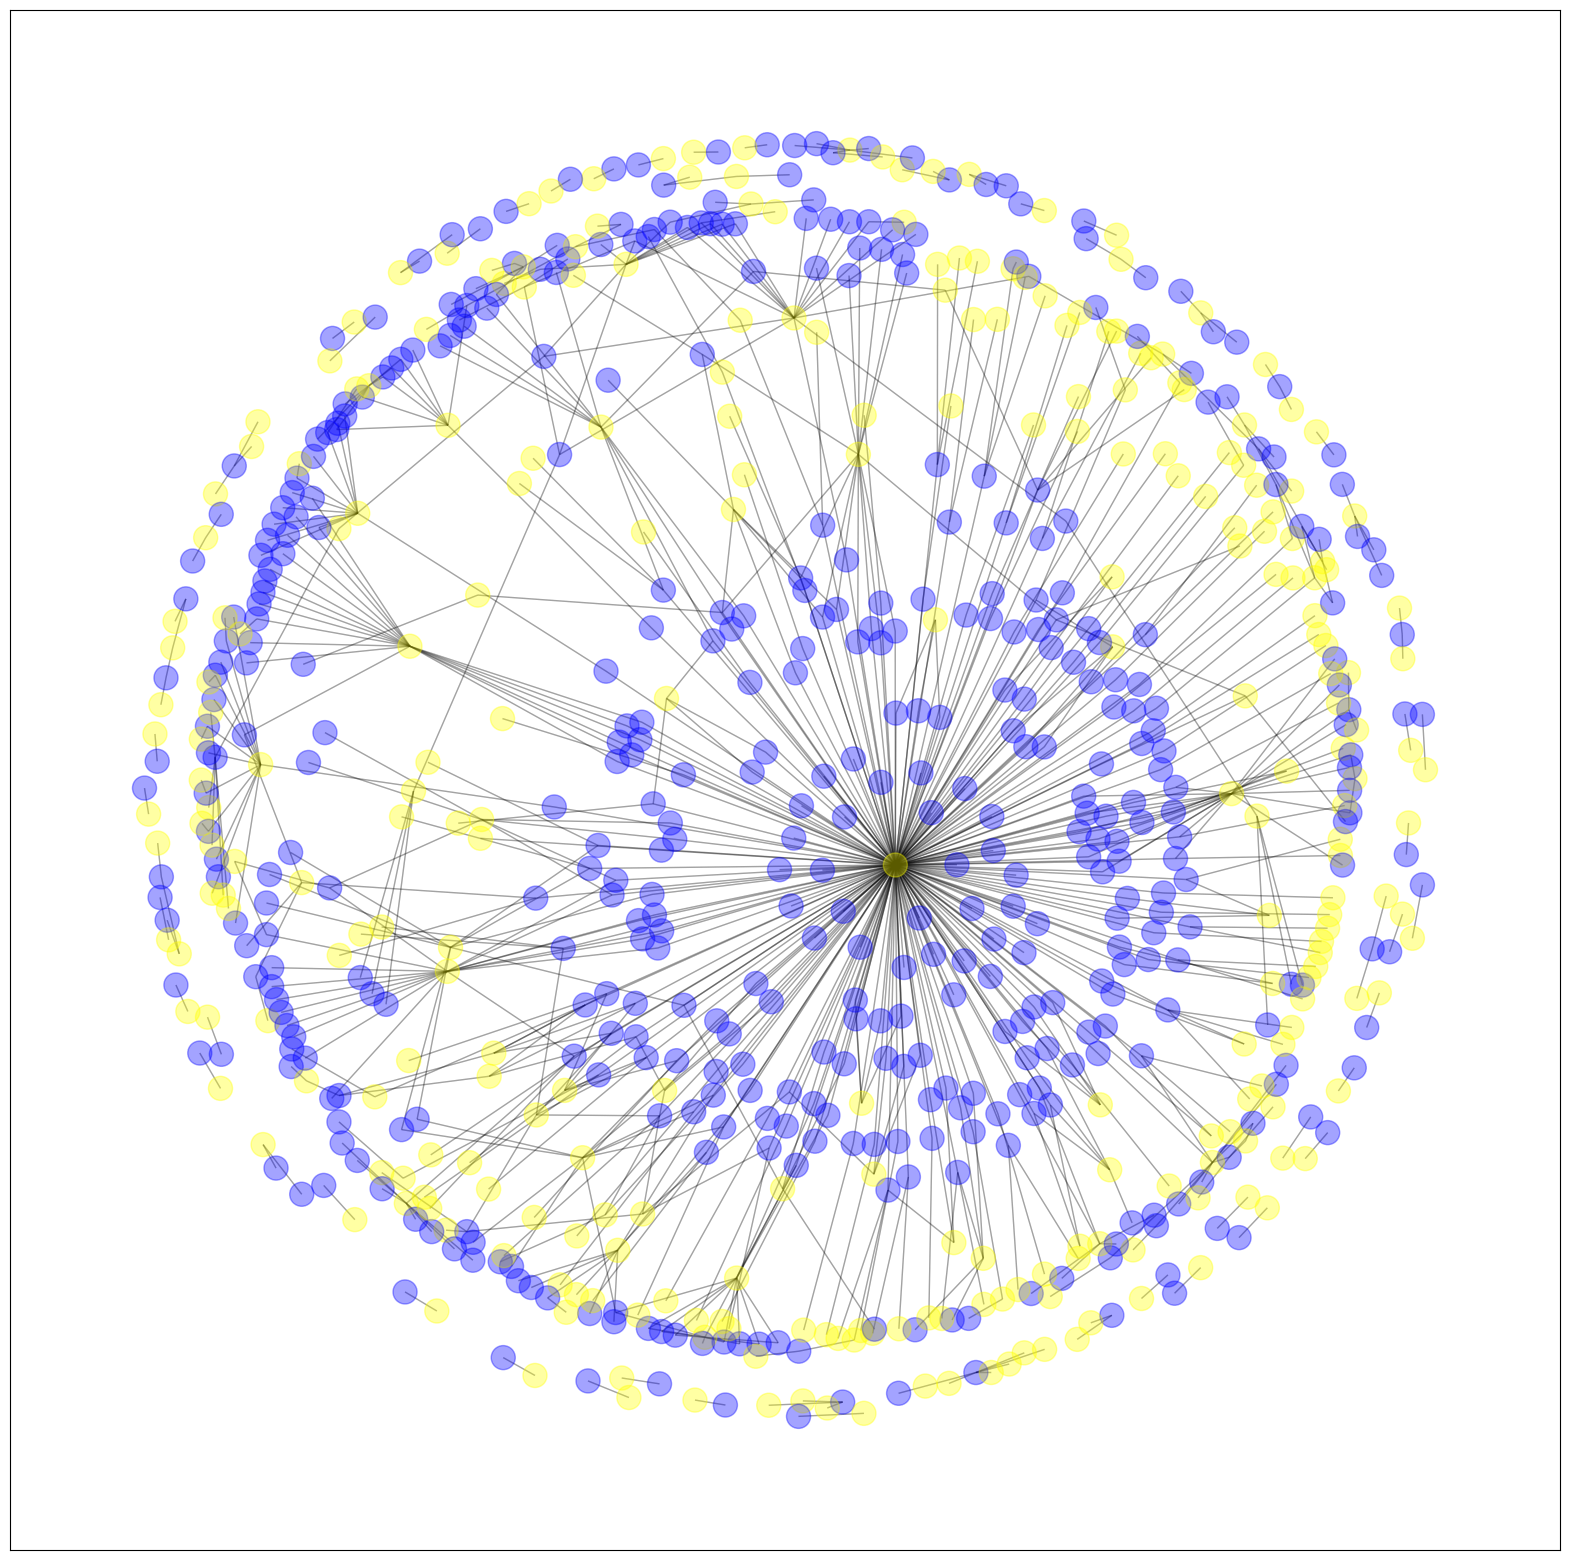

Graph for commit contributors should have just printed
current time:- 2023-07-06 19:16:13.767242
issue contributor graph


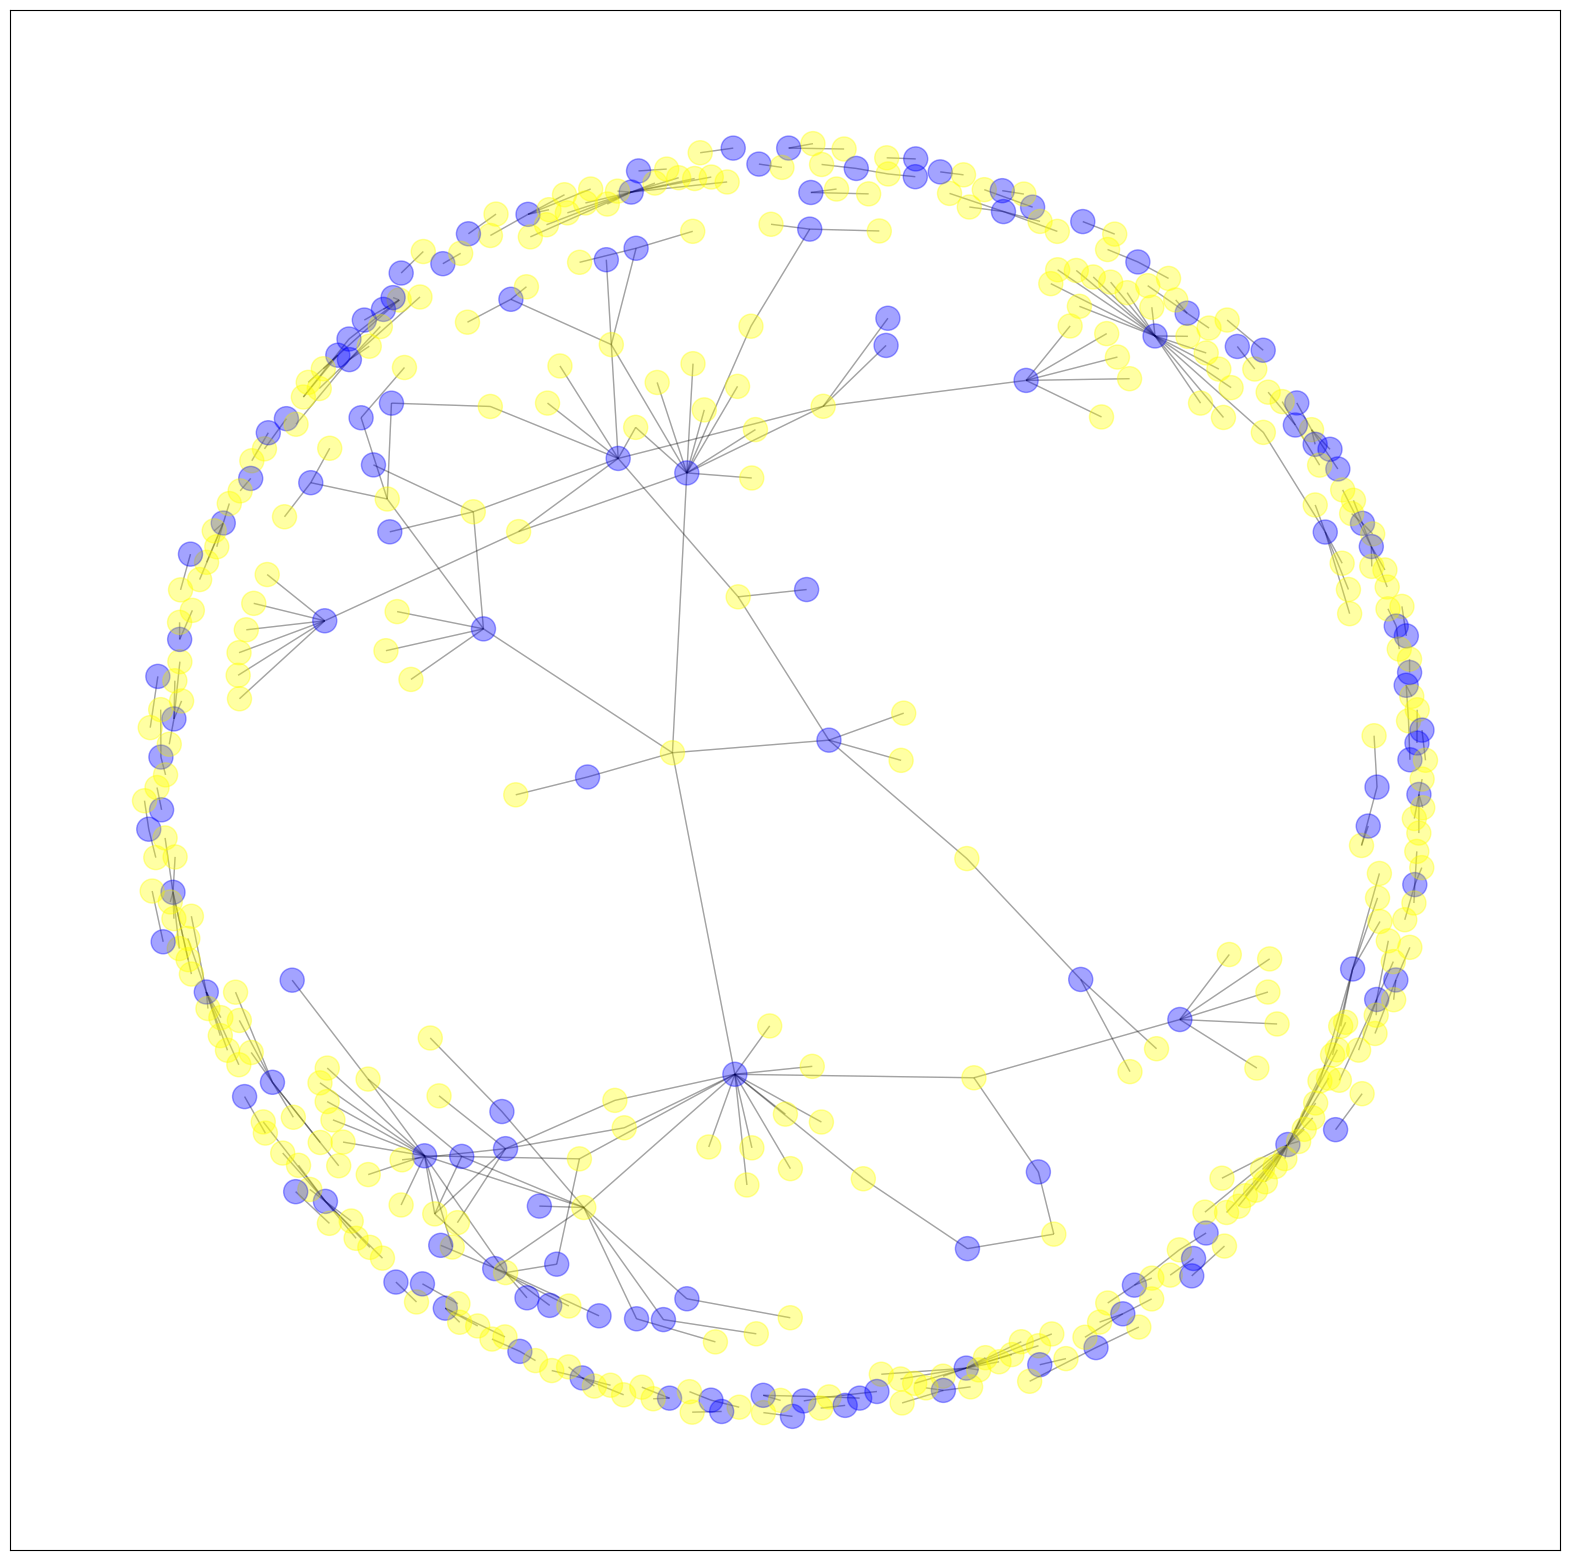

Graph for issue contributors should have just printed
current time:- 2023-07-06 19:16:15.699537
PR contributor graph


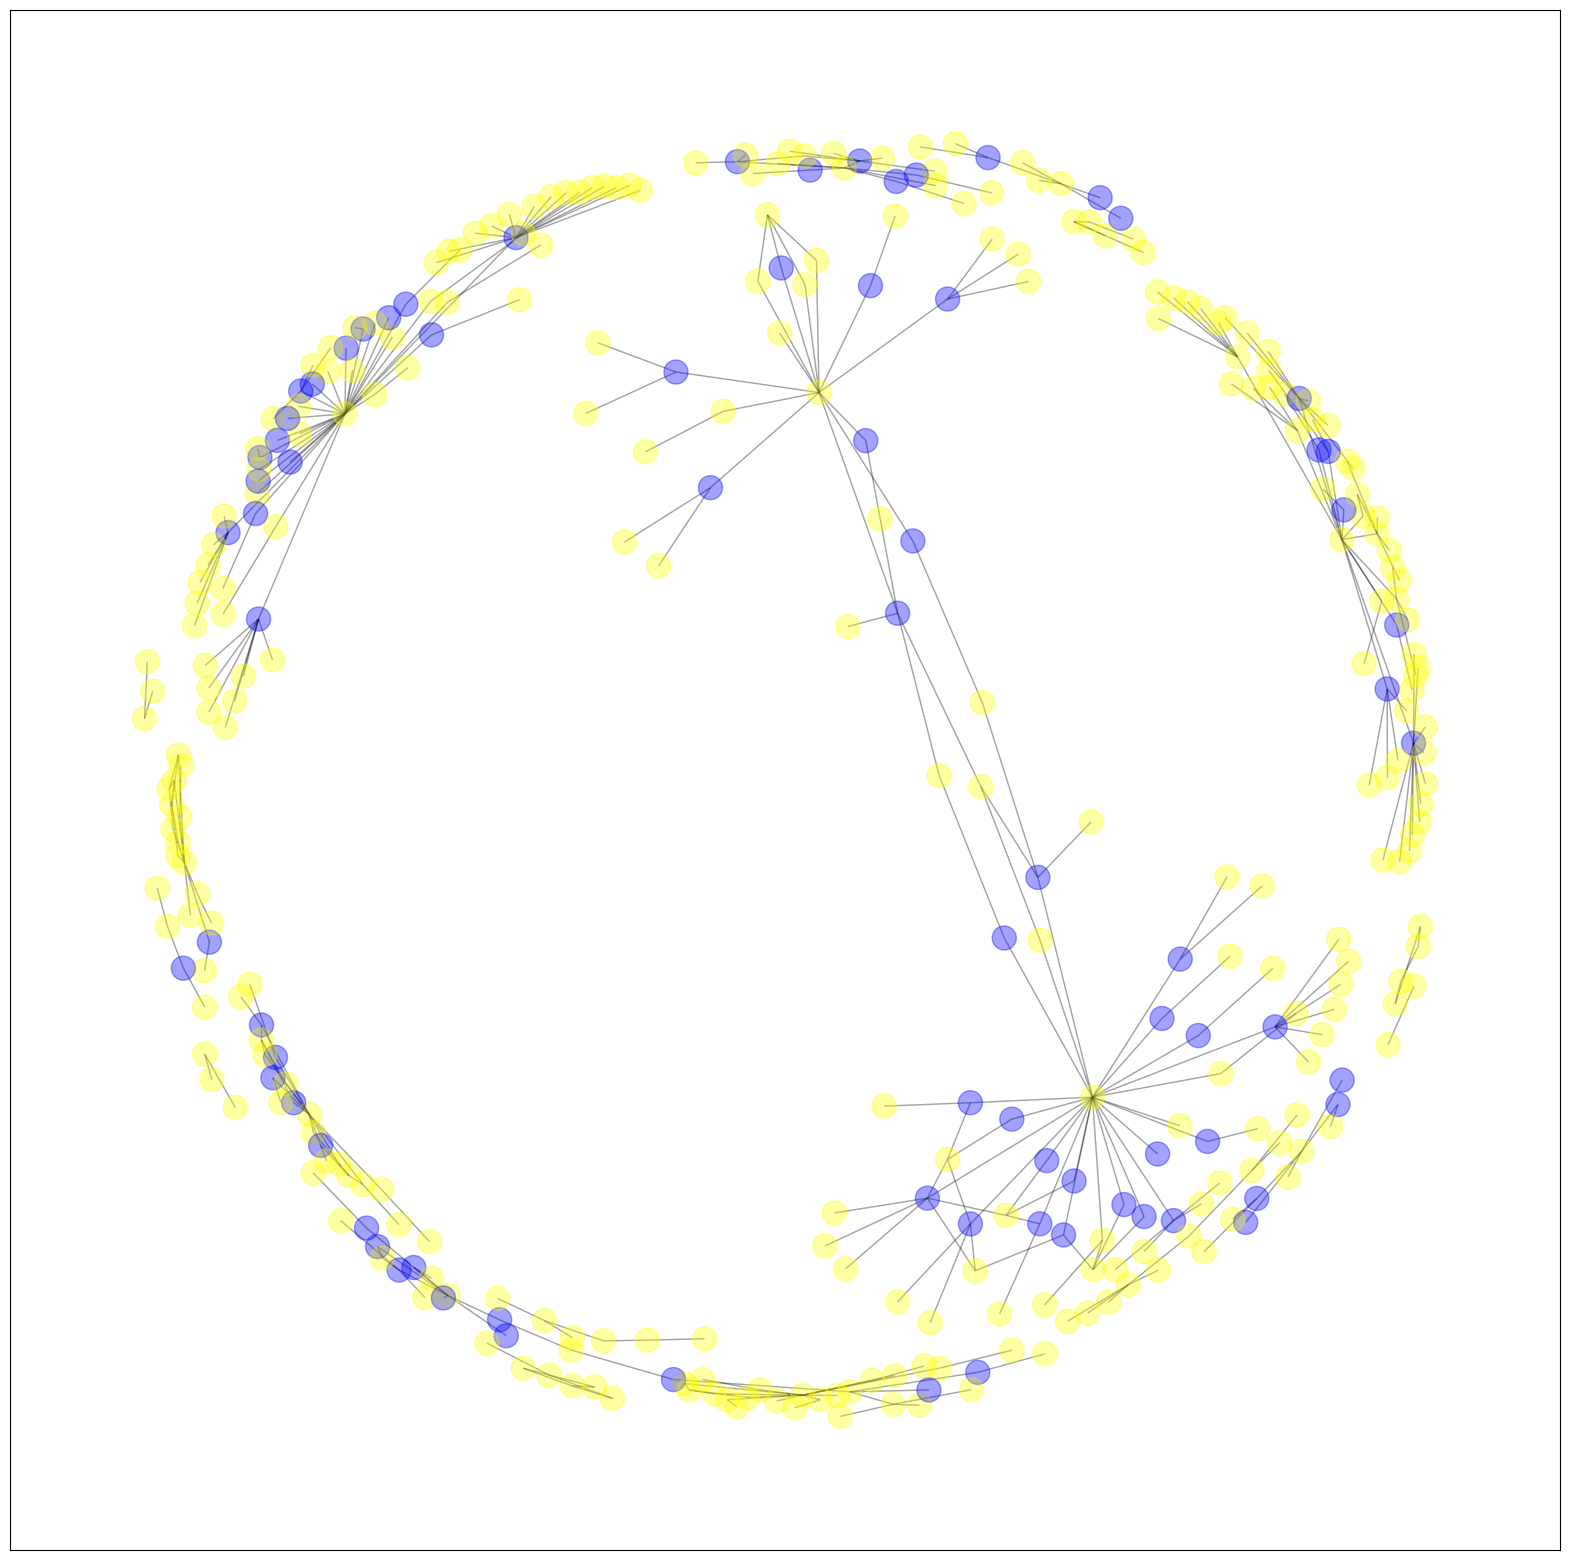

Graph for PR contributors should have just printed
current time:- 2023-07-06 19:16:17.446016
PR REVIEW contributor graph


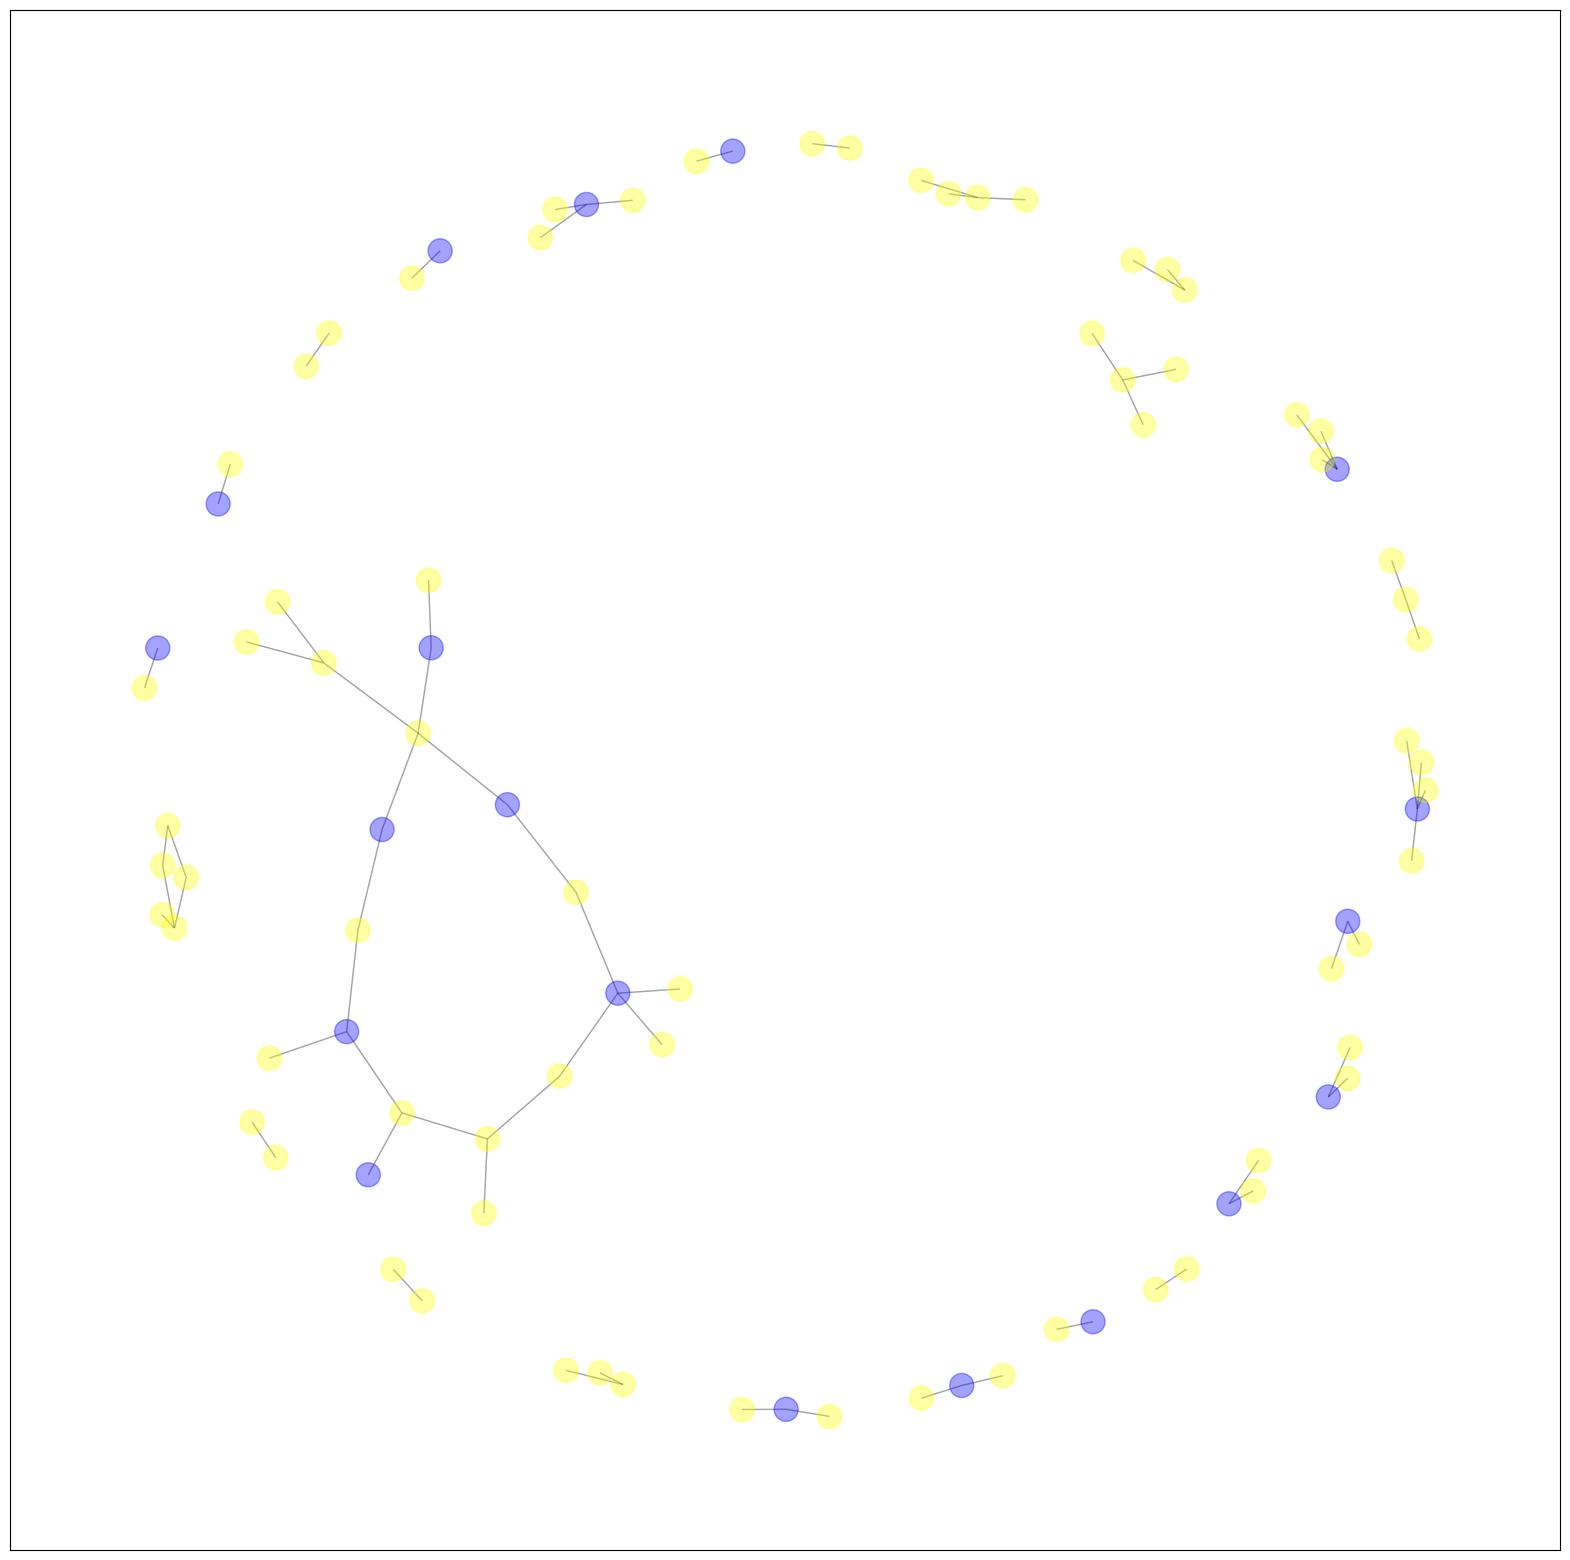

Graph for PR REVIEW contributors should have just printed
current time:- 2023-07-06 19:16:18.249784
Graphs for NTILE: 2
Starting Data Collection for NTILE: 2
current time:- 2023-07-06 19:16:18.250530


In [ ]:
#find unique ntile values
ntiles = df_results.ntile.unique()
display(df_results) 
#sort values smallest to largest
ntiles.sort()

#display sorted values
display(ntiles)

#run analysis in ntiles
#surveys_df[surveys_df.year == 2002]

for i in ntiles:
    repo_set=[]
    repo_git_set = []
    repo_name_set = []
    result_tile = df_results[df_results.ntile==i]
    #print(i)
    #print(result_tile)

    
    print("Graphs for NTILE: " + str(i))
    print('Starting Data Collection for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

#    for index, row in result_tile.iterrows():
    for row in result_tile.itertuples(index = True):
        trepo_git=getattr(row,"repo_git")
        #fdisplay(trepo_git)
        
        repo_query = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                     SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{trepo_git}'
            """)
        with engine.connect() as conn:
            results = conn.execute(repo_query)
            df2_results = pd.DataFrame(results) 
        df2_results.reset_index(drop=True, inplace=True) 
        repo_id = int(df2_results['repo_id'].values[0])
        repo_name = df2_results['repo_name'].to_string(index=False)
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)
        repo_git_set.append(trepo_git)    

    print("Graphs for NTILE: " + str(i))
    print('Finished itertuples for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

    repo_all = '('
    
    for repo_id in repo_set:
        repo_all = repo_all + str(repo_id) + ','
    
    repo_all = repo_all.rstrip(repo_all[-1])
        
    repo_all = repo_all + ')'
    print(repo_all)

    #Issue Contributors
    issue_contrib = pd.DataFrame()
    #for repo_id in repo_set:
        
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                i.reporter_id as cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id in {repo_all} AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])
    
    issue_contrib = issue_contrib.reset_index()
    issue_contrib.drop("index", axis=1, inplace=True)
    issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
    display(issue_contrib)
    #issue_contrib.dtypes   
    
    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for ISSUES in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)
        
    #PR Contributors
    pr_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id in {repo_all} AND
                prm.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])
    
    pr_contrib = pr_contrib.reset_index()
    pr_contrib.drop("index", axis=1, inplace=True)
    pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
    display(pr_contrib)
    #pr_contrib.dtypes

    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for PULL REQUESTS in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)


    #PR Reviewers
    prr_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id in {repo_all} AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])
    
    prr_contrib = prr_contrib.reset_index()
    prr_contrib.drop("index", axis=1, inplace=True)
    prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
    display(prr_contrib)
    #prr_contrib.dtypes
    
    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for PR REVIEWERS in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

    # Commit Contributors
    commit_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id in {repo_all} AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])
    
    commit_contrib = commit_contrib.reset_index()
    commit_contrib.drop("index", axis=1, inplace=True)
    commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
    display(commit_contrib)
    #commit_contrib.dtypes


###########################################################################

    print('Completed ALL Data Collection for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    # Commit Contributor Graph
    df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_commit.head()
    df_commit = df_commit.reset_index()
    
    df_melted_commit = df_commit.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')
    
    df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
    df_melted_commit.head()
    G = nx.from_pandas_edgelist(df_melted_commit, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    Repo_id = df_melted_commit['repo_id'].to_list()
    contributor_id = df_melted_commit['cntrb_id'].to_list()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    #yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
    #blue_patch = mpatches.Patch(color='blue', label='Repository')
    #ax.legend(handles=[yellow_patch, blue_patch])
    print('commit contributor graph')
  

    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "commit_contributor_graph_ntile_" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    #nx.draw_networkx(G, node_color=colors, with_labels=False, font_size=8, ax=ax)
    print('Graph for commit contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    # Issue Contributor Graph
    df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_issue = df_issue.reset_index()
    df_melted_issue = df_issue.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]

    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_issue, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]
    fig, ax = plt.subplots(figsize=(20,20))
    #ax.legend(handles=[yellow_patch, blue_patch])
    print('issue contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "issue_contributor_graph_ntile_" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   

    
    print('Graph for issue contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    ### PR Contributor Graph
    df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_pr = df_pr.reset_index()
    df_melted_pr = df_pr.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_pr, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())

    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.fruchterman_reingold_layout(G)
    print('PR contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "PR_contributor_graph_ntile_" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    print('Graph for PR contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################

    ### PR REVIEWER Contributor Graph
    df_pr = prr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_pr = df_pr.reset_index()
    df_melted_pr = df_pr.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_pr, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())

    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.fruchterman_reingold_layout(G)
    print('PR REVIEW contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "PR_contributor_graph_ntile_" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    print('Graph for PR REVIEW contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

    ## Nodes as projects edge as contributors
    #  In this section, we represent data differently and try out another graph representation where nodes represent the project repositories, and the edges are shared contributions between those projects

    print('contributor graph: Nodes as projects, edges as contributors')
    #    print(`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of 
    #**"shared connections"** between them. Let's explain **"connected"** repositories and shared "connections.")
    #**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
    #We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
    #This means if they have a contributor who makes a *commit*, *pull request*, *issue*, or *pull request review* in both repositories, 
    # they count as a shared contributor, and the repositories are connected. 

    #structure of `contributorGraph` =  
       # {  
       # `repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
       # `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
       # }

#We track the number of shared contributions between 2 repositories for creating this graph plot.
    contributorGraph = {}
    for i, row in df_melted_pr.iterrows():
        if row['cntrb_id'] not in contributorGraph:
            contributorGraph[row['cntrb_id']] = []
        if(row['number'] > 0):
            contributorGraph[row['cntrb_id']].append((row['repo_id'], row['number']))

    commonRepoContributionsByContributor = collections.defaultdict(int)
    for key in contributorGraph:
        if len(contributorGraph[key])-1 <= 0:
            continue
        for repoContributionIndex in range(len(contributorGraph[key])-1):
            commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
    res = []
    for key in commonRepoContributionsByContributor:
        res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

    G = nx.Graph()
    G.add_weighted_edges_from(res)
    
    fig, ax = plt.subplots(figsize=(30,30))

    pos = nx.fruchterman_reingold_layout(G)
    #spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=pos, alpha=0.2, font_size=7, ax=ax)
    filename = "2_repo_contributors_contributor_graph_ntile_" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   

    nx.draw_networkx(g, node_size=120, with_labels=False, font_size=14, ax=ax)
    print('Graph for Nodes:Projects, Edges: Contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.